## Setup the problem

In [1]:
from jax import numpy as jnp
import numpy as np


In [2]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources, Sensors
from jwave.physics import simulate_wave_propagation

N = (256, 256)
dx = (.5, .5)

cfl = 0.25

grid = kGrid.make_grid(N, dx)

In [3]:
# Physical properties
sound_speed = jnp.ones(N) 
#sound_speed = sound_speed.at[50:100,50:80].set(2.)

# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=20
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=120.)
output_time_array = time_array

In [4]:
# define a source point
from jwave.signal_processing import apply_ramp

source_freq = .8
source_mag = 5/time_array.dt

def gaussian_window(signal, time, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

t = jnp.arange(0, time_array.t_end, time_array.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_array.dt, source_freq),
    t,
    6,
    1.5
)

source_signals = jnp.stack([s1])
source_positions = ([128], [32])

sources = Sources(positions=source_positions, signals=source_signals)

In [5]:
# Define sensors
x_pos = list(range(32,150)) + [190]
y_pos = [220]*len(x_pos)
sensors_positions = (x_pos, y_pos)
sensors = Sensors(positions=sensors_positions)

Let's look at the problem setup

Text(0.5, 1.0, 'Source signals')

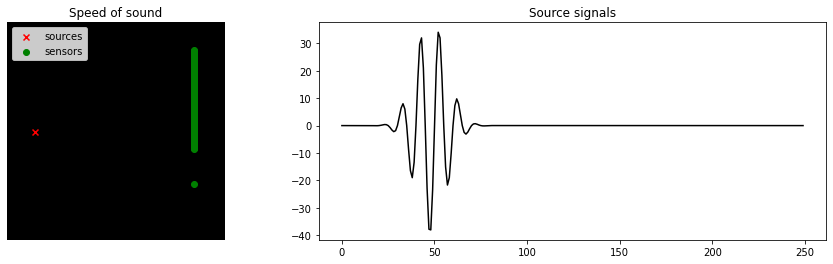

In [6]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="gray")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(s1[:250], label="Source 1", c='k')
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

## Run the simulation

In [7]:
# Run simulation
fields = simulate_wave_propagation(grid, medium, time_array, sources, sensors,
                                  output_t_axis = output_time_array)
u = fields[0]
p = jnp.sum(fields[1],1)*(medium.sound_speed[sources.positions]**2)

In [8]:
p.shape

(960, 119)

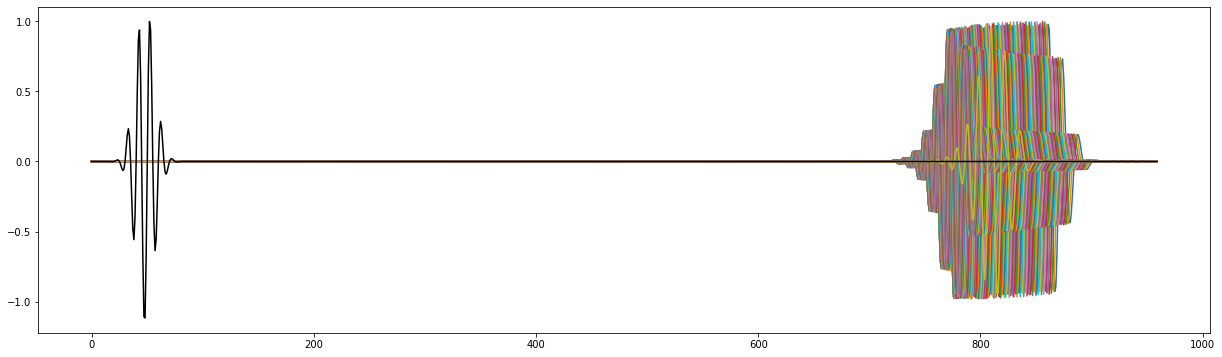

In [9]:
plt.figure(figsize=(21,6))
plt.plot(p/jnp.amax(p))
plt.plot(s1/jnp.amax(s1), label="Source 1", c='k')

## Define the optimization problem

In [10]:
from jax import random, nn, value_and_grad, jit, jvp, grad, vmap, jacfwd
from jax import lax

key = random.PRNGKey(42)

In [11]:
from jax.ops import index, index_add
from jwave.signal_processing import smooth

def _get_sound_speed(sos_patch, start_point=40, height=4, width=10):
    base_sos = jnp.ones(N)
    new_sos = base_sos.at[
        start_point:start_point+sos_patch.shape[0],
        65:65+sos_patch.shape[1]].add(nn.sigmoid(sos_patch))
    return smooth(new_sos)


def get_sound_speed(segments_sos):
    return _get_sound_speed(segments_sos)

In [12]:
key, _ = random.split(key)
segments_sos = random.normal(key, shape=(180,100))*0 -3

sos = get_sound_speed(segments_sos)

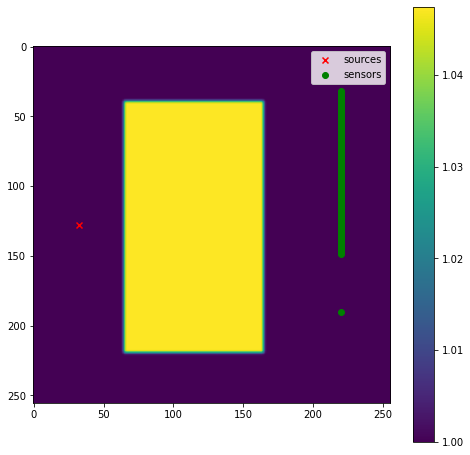

In [13]:
plt.figure(figsize=(8,8))

plt.imshow(sos)
plt.colorbar()
plt.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
plt.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
plt.legend()


In [14]:
time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=200.)
output_time_array = TimeAxis(dt = time_array.dt, t_end = time_array.t_end)

Note that `simulate_wave_propagation` has the flag arument `checkpoint=True`. This [makes gradient computation longer but saves memory](https://jax.readthedocs.io/en/latest/jax.html#jax.checkpoint): useful if the whole computational graph doesn't fit in the GPU.

In [16]:
def loss_func(p):
    '''
    Maximizes energy at bottom sensor, minimize energy on top ones'''
    return jnp.sum(p[:,:-2]**2) - jnp.sum(p[:,-1]**2)
    #return -jnp.sum(jnp.abs(p[:,-1])**2)
                
def get_sensor_signals(segments_sos):
    medium = Medium(
        sound_speed=get_sound_speed(segments_sos),
        density=1.,
        attenuation=0.0,
        pml_size=12
    )
    
    fields = simulate_wave_propagation(grid, medium, time_array, sources, sensors,
                                  output_t_axis = output_time_array, backprop=True, checkpoint=True)
    p = jnp.sum(fields[1],1)*(medium.sound_speed[sources.positions]**2)
    return p

# This is using forward differentiation
'''
def loss_with_grad(segments_sos):
    def jac_vec_prod(jacobian, vector):
        return jnp.sum(jacobian*vector, axis=(-1,-2))
    
    # parallel evaluation of jacobian vector products to explicitly buil jacobian matrix
    batched_jvp = vmap(lambda x: jvp(get_sensor_signals, (segments_sos,), (x,)))
    p, jacobian = batched_jvp(jnp.eye(segments_sos.shape[0]))
    lossval, lossgrad = value_and_grad(loss_func)(get_sensor_signals(segments_sos))
    gradient = jac_vec_prod(jacobian, lossgrad)
    return lossval, gradient
'''

# This is using backward differentiation
def loss_with_grad(segments_sos):
    lossval, gradient = value_and_grad(
        lambda x: loss_func(get_sensor_signals(x))
    )(segments_sos)
    return lossval, gradient

## Optimize

In [17]:
from tqdm import tqdm
from jax.experimental import optimizers

In [18]:
loss, gradient = loss_with_grad(segments_sos)
print(loss)

1.1025112


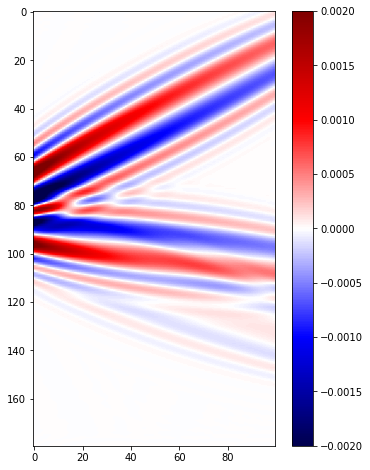

In [19]:
plt.figure(figsize=(6,8))
plt.imshow(gradient, cmap="seismic", vmin=-0.002, vmax=0.002)
plt.colorbar()

In [21]:
losshistory = []

init_fun, update_fun, get_params = optimizers.adam(0.05, b1=0.8, b2=0.9)
opt_state = init_fun(segments_sos)

@jit
def update(opt_state):
    v = get_params(opt_state)
    lossval, gradient = loss_with_grad(v)
    return lossval, update_fun(k, gradient, opt_state)

pbar = tqdm(range(1000))
for k in pbar:
    lossval, opt_state = update(opt_state)
    
    # For logging
    new_segments_sos = get_params(opt_state)
    losshistory.append(lossval)
    
    pbar.set_description("Loss: {}".format(lossval))

Loss: -1.7406997680664062: 100%|██████████| 1000/1000 [11:41<00:00,  1.43it/s]


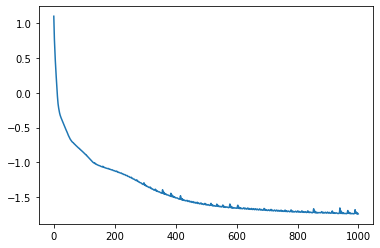

In [22]:
plt.plot(losshistory)

In [23]:
p_new = get_sensor_signals(new_segments_sos)
p = get_sensor_signals(segments_sos)

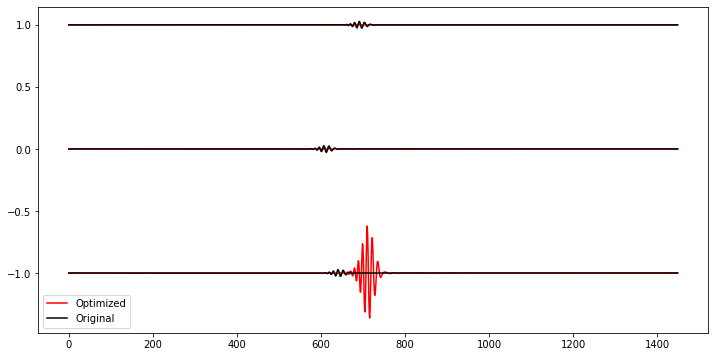

In [24]:
plt.figure(figsize=(12,6))
plt.plot(p_new[150:,0] + 1, 'r', label="Optimized")
plt.plot(p_new[150:,-2], 'r')
plt.plot(p_new[150:,-1] - 1, 'r')

plt.plot(p[150:,0] + 1, 'k', label="Original")
plt.plot(p[150:,-2], 'k')
plt.plot(p[150:,-1] - 1, 'k')

plt.legend()

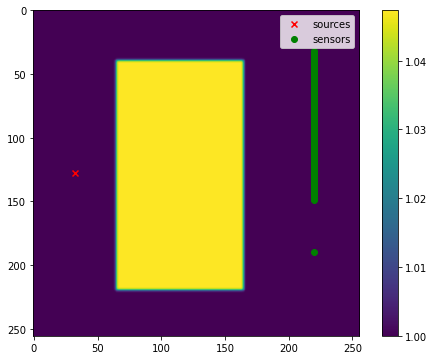

In [25]:
sos = get_sound_speed(segments_sos)

plt.figure(figsize=(8,6))

plt.imshow(sos)
plt.colorbar()
plt.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
plt.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='o', label="sensors")
plt.legend()

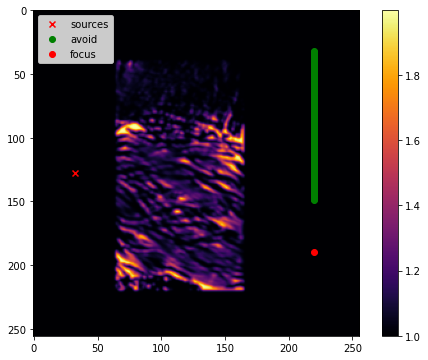

In [26]:
sos = get_sound_speed(new_segments_sos)

plt.figure(figsize=(8,6))

plt.imshow(sos, cmap="inferno")
plt.colorbar()
plt.scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
plt.scatter(sensors_positions[1][:-1],sensors_positions[0][:-1], c='g', marker='o', label="avoid")
plt.scatter(sensors_positions[1][-1],sensors_positions[0][-1], c='r', marker='o', label="focus")
plt.legend()